# ClimateNet AR/TC Analysis (Extreme Precip)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime # need cftime < 1.5 or nc-time-axis won't work (https://github.com/SciTools/nc-time-axis/issues/58)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluste

In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/33380/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/33380/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.47:35003,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/33380/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Close cluster/client as needed
Do I need both these commands?

In [44]:
cluster.close()
#client.close()

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/work/k

### Set ClimateNet filepath

In [4]:
cesm_cnet_filepath = "/glade/campaign/cgd/amp/jet/ClimateNet/"

In [5]:
cesm_cnet_folders = ["output.cgnet.2000/", "output.cgnet.2001/", "output.cgnet.2002/", "output.cgnet.2003/", "output.cgnet.2004/", "output.cgnet.2005/"]
cesm_cnet_folders

['output.cgnet.2000/',
 'output.cgnet.2001/',
 'output.cgnet.2002/',
 'output.cgnet.2003/',
 'output.cgnet.2004/',
 'output.cgnet.2005/']

## CESM historical simulation, 2000-2005

In [6]:
cnet_files = "b.e13.B20TRC5CN.ne120_g16.003*.nc"

In [7]:
# start with year 2000 only to solidfy workflow
cnet = xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[0]+cnet_files, concat_dim='time', combine="nested", chunks={'time':360}, parallel=True) # aim for chunk size < 100mb
cnet

<xarray.Dataset>
Dimensions:     (lat: 768, lon: 1152, time: 2920)
Coordinates:
  * time        (time) datetime64[ns] 1999-11-26T03:00:00 ... 2000-11-25
  * lon         (lon) float32 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
  * lat         (lat) float32 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
Data variables:
    output_tag  (time, lat, lon) uint8 dask.array<chunksize=(10, 768, 1152), meta=np.ndarray>

In [8]:
# need to fix time...starting in November (see John's email)
cnet.time

<xarray.DataArray 'time' (time: 2920)>
array(['1999-11-26T03:00:00.000000000', '1999-11-26T06:00:00.000000000',
       '1999-11-26T09:00:00.000000000', ..., '2000-11-24T18:00:00.000000000',
       '2000-11-24T21:00:00.000000000', '2000-11-25T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1999-11-26T03:00:00 ... 2000-11-25
Attributes:
    long_name:  time

In [9]:
cnet_mask = cnet.output_tag
cnet_mask

<xarray.DataArray 'output_tag' (time: 2920, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(2920, 768, 1152), dtype=uint8, chunksize=(10, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1999-11-26T03:00:00 ... 2000-11-25
  * lon      (lon) float32 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float32 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  segmentation tag

### Read in precipitation field

In [10]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/" # need to be on casper, CESM historical output

In [11]:
# h4.PRECT is 3hrly instantaneous
# remapped from unstructured grid to FV (still 1/4 degree so will not completely match frontal ID)
#PRECT_hist_files = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT*FV.nc"
PRECT_hist_file = "b.e13.B20TRC5CN.ne120_g16.003.cam.h4.PRECT.2000010100Z-2000123121Z.FV.nc" # testing year 2000 only

preprocessing function to return PRECT only

In [12]:
def preprocess(ds):
    return ds['PRECT']

read in PRECT files with preprocessing function

In [12]:
%%time
#PRECT_hist = xr.open_mfdataset(cesm_hist_filepath+PRECT_hist_files, concat_dim='time', combine="nested", chunks={'time':500,'lat':100,'lon':200}, parallel=True, preprocess=preprocess)
PRECT_hist = xr.open_dataset(cesm_hist_filepath+PRECT_hist_file, chunks={'time':500,'lat':100,'lon':200})

CPU times: user 278 ms, sys: 62.1 ms, total: 340 ms
Wall time: 3.85 s


In [13]:
#PRECT_hist
PRECT_hist.PRECT

<xarray.DataArray 'PRECT' (time: 2920, lat: 768, lon: 1152)>
dask.array<open_dataset-4bfa623bf9287813d38c4053d6e7ae12PRECT, shape=(2920, 768, 1152), dtype=float32, chunksize=(500, 100, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-01 03:00:00 ... 2001-01-01 00:00:00
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_measures:  area: area

### Calculate 90th percentile precipitation at each gridpoint

In [14]:
#p90 = PRECT_hist.chunk({'time': -1}).quantile(0.9, dim='time')
p90 = PRECT_hist.PRECT.chunk({'time': -1}).quantile(0.9, dim='time')

In [15]:
p90

<xarray.DataArray 'PRECT' (lat: 768, lon: 1152)>
dask.array<getitem, shape=(768, 1152), dtype=float64, chunksize=(100, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon       (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
    quantile  float64 0.9

### Select gridpoints where precipitation at a given time is greater than p90

In [16]:
#PEx = PRECT_hist.where(PRECT_hist > p90)
PEx = PRECT_hist.PRECT.where(PRECT_hist.PRECT > p90)

In [17]:
PEx

<xarray.DataArray 'PRECT' (time: 2920, lat: 768, lon: 1152)>
dask.array<where, shape=(2920, 768, 1152), dtype=float32, chunksize=(500, 100, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon       (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time      (time) object 2000-01-01 03:00:00 ... 2001-01-01 00:00:00
    quantile  float64 0.9
Attributes:
    units:          m/s
    long_name:      Total (convective and large-scale) precipitation rate (li...
    cell_measures:  area: area

CPU times: user 15.8 s, sys: 605 ms, total: 16.4 s
Wall time: 2min 48s


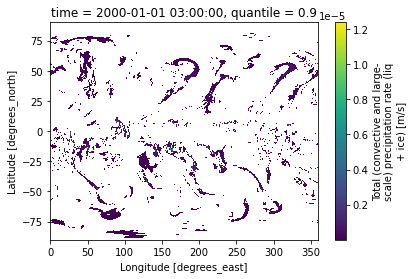

In [39]:
%%time
PEx.isel(time=0).plot();

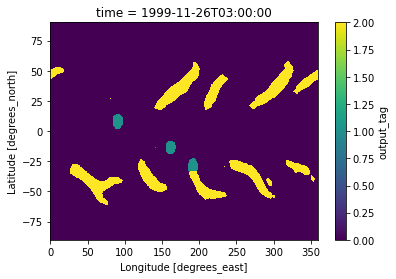

In [23]:
# ARs/TCs at the same time index(?)
cnet_mask.isel(time=0).plot();

### Find gridpoints that overlap (AR/TC & PEx)
Running out of memory for these steps (even with just year 2000) - maybe launch jupyter on compute node for >4GB memory and/or modify client memory and workflow to reduce data sizes

In [ ]:
#cnet_mask.isel(time=0).where(cnet_mask==2).plot();

In [19]:
# need to fix this logic for the cnet_mask array
PEx_cnet = PEx.where(cnet_mask==2 | cnet_mask==1)

CommClosedError: in <closed TCP>: Stream is closed

In [ ]:
PEx_cnet